# NSGA-II príklad

Zdrojový kód príkladu prevzatý z [Github repozitára](https://github.com/DEAP/deap/blob/master/examples/ga/nsga2.py).

In [1]:
import array
import random
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from math import sqrt

from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools

Pomocou akejsi DEAP meta factory vytvoríme dva objekty:

- FitnessMin, ktorý reprezentuje fitness jedinca s váhami pre jednotlivé účelové funkcie
- Individual, ktorý reprezentuje jedinca s určitým fitness.

Prvý argument je názov triedy, ktorú ideme vytvárať, druhý argument je trieda, od ktorej dedí. V prípade `Individual` triedy je to pole z `array` modulu, ale vystačili by sme si pravdepodobne aj s obyčajným `list`.

Všetky ostatné argumenty sú potom atribúty danej triedy.

In [2]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)

*TODO: doplniť opis*

In [9]:
# Problem definition
# Functions zdt1, zdt2, zdt3, zdt6 have bounds [0, 1]
BOUND_LOW, BOUND_UP = 0.0, 1.0

# Functions zdt4 has bounds x1 = [0, 1], xn = [-5, 5], with n = 2, ..., 10
# BOUND_LOW, BOUND_UP = [0.0] + [-5.0]*9, [1.0] + [5.0]*9

# Functions zdt1, zdt2, zdt3 have 30 dimensions, zdt4 and zdt6 have 10
NDIM = 2

def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

V ďalšej fáze sa obšírne používa metóda [`register`](http://deap.readthedocs.io/en/master/api/base.html#deap.base.Toolbox.register), ktorá funguje podobne ako `creator.create`, ale nevytvára triedy, ale funkcie, pričom:

- prvý argument je alias danej funkcie (ktorá potom bude prístupná v `toolbox`),
- druhý je samotná funkcia,
- všetky ostatné sú argumenty danej funkcie. Je možné zadať rovno všetky argumenty, ako je to v prípade `attr_float`, alebo je možné zadať len potrebné, s tým že ostatné sa doplnia priamo pri volaní metódy z toolboxu (ako v prípade `population`).


[`initRepeat`](http://deap.readthedocs.io/en/master/api/tools.html#deap.tools.initRepeat) a [`initIterate`](http://deap.readthedocs.io/en/master/api/tools.html#deap.tools.initIterate) sú podobné metódy, pomocou ktorých sa dá dosiahnúť to isté, len iným spôsobom.

Zvyšné sú potom už len evolučné operátory [kríženia](http://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxSimulatedBinaryBounded), [mutácie](http://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutPolynomialBounded) a [selekcie](http://deap.readthedocs.io/en/master/api/tools.html#deap.tools.selNSGA2), konkrétne pre algoritmus NSGA-II.

**To čo mňa najviac trápi** je v podstate iba `evaluate` funkcia, zaregistrovaná v toolboxe tu, nižšie (`benchmarks.zdt1`). Podľa všetkého tam treba iba šupnúť nejakú funkciu, ktorá vráti `tuple` funkčných hodnôť (jedna bude teda pre cenu energie, druhá bude MAPE).

In [83]:
toolbox = base.Toolbox()
    
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", benchmarks.zdt1)
# tieto by sme v podstate ani nemuseli registrovat, teoreticky by sme to v hlavnom cykle vedeli
# rovno s pouzitim metod z tools modulu, toto je v podstate len pre pohodlnost,
# aby sme nemuseli v tych volaniach stale dookola pisat aj BOUND_LOW/UP, eta a pod.
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

# toto je trochu ofajc, nepouziva sa to naozaj na selekciu, ale na zoradenie podla stupna frontu:
# http://deap.readthedocs.io/en/master/api/tools.html#deap.tools.selNSGA2
# prvy argument je populacia z ktorej ideme vyberat, druhy argument je pocet jedincov, ktore chceme vybrat
# ak je pocet jedincov ktore chceme vybrat rovnaky ako pocet jedincov v generacii, vrati vsetkych, akurat
# zoradenych
toolbox.register("select", tools.selNSGA2)

Hlavný cyklus algoritmu, používa sa tam metóda [selekcie pre NSGA-II](http://deap.readthedocs.io/en/master/api/tools.html#deap.tools.selTournamentDCD).

In [63]:
def main(seed=None, gens=100):
    random.seed(seed)

    
    NGEN = gens  # pocet generacii
    MU = 100    # pocet jedincov v populacii
    CXPB = 0.9  # pravdepodobnost krizenia?

    stats = tools.Statistics(lambda ind: ind.fitness.values)    
    # stats.register("avg", numpy.mean, axis=0)
    # stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)
   
    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"
 
    # vytvorime inicialnu populaciu
    pop = toolbox.population(n=MU)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    pop = toolbox.select(pop, len(pop))
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    #print(logbook.stream)

    # Begin the generational process
    for gen in range(1, NGEN):
        # Vary the population
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]

        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= CXPB:
                toolbox.mate(ind1, ind2)            

            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            del ind1.fitness.values, ind2.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Select the next generation population
        pop = toolbox.select(pop + offspring, MU)
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        #print(logbook.stream)

    print("Final population hypervolume is %f" % hypervolume(pop, [11.0, 11.0]))

    return pop, logbook

Final population hypervolume is 120.660749


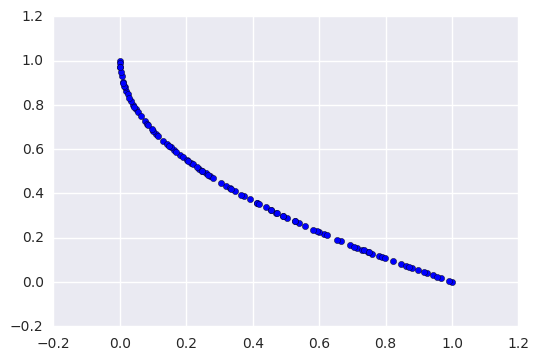

In [86]:
pop, logbook = main(gens=100)

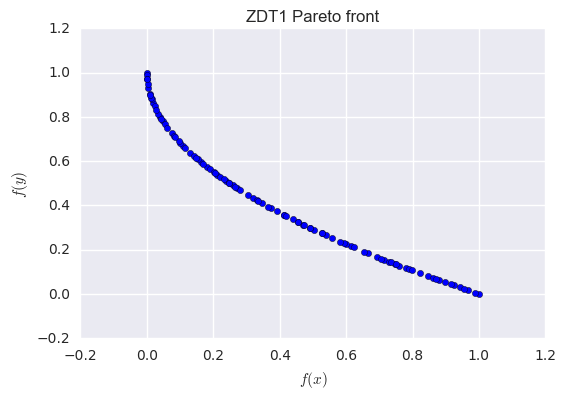

In [92]:
pop = np.array(pop)
f_values = np.array([toolbox.evaluate(x) for x in pop])
plt.scatter(f_values[:,0], f_values[:,1])
plt.title('ZDT1 Pareto front')
plt.xlabel('$f(x)$')
plt.ylabel('$f(y)$')
plt.savefig('zdt1-pf')

In [93]:
help(hypervolume)

Help on function hypervolume in module deap.benchmarks.tools:

hypervolume(front, ref=None)
    Return the hypervolume of a *front*. If the *ref* point is not
    given, the worst value for each objective +1 is used.
    
    :param front: The population (usually a list of undominated individuals)
                  on which to compute the hypervolume.
    :param ref: A point of the same dimensionality as the individuals in *front*.

